In [3]:
from evaluations import *
from partitioner import build_subspaces, partition_any_grid
from discrete_pou import *

Loading pyMOR version 0.4.2-116-gadb475af


In [2]:
p = maxwell_problem()
diameter = 1./200
d, data = discretize_maxwell(p, diameter = diameter)
mus = {'c_loc' : 1. / 376.730313 *1./200, 'k': 1e9*2*np.pi, 'mu': 4*np.pi*1e-7, 'eps': 8.854187817e-12}
u = d.solve(mus)

/home/root_dennis/pymor_MA/src/pymor/gui/qt.py:282: ComplexWarning: Casting complex values to real discards the imaginary part
  tuple(u.data.astype(np.float64, copy=False) for u in U)


In [4]:
coarse_grid_resolution = 10
dof_codim = 1 # codim of grid entities for dofs
localization_codim = 2
grid = data["grid"]
dmask = data['boundary_info'].dirichlet_mask(2)
subspaces, subspaces_per_codim = build_subspaces(*partition_any_grid(grid, num_intervals=(coarse_grid_resolution, coarse_grid_resolution), dmask = dmask, codim = dof_codim))
spaces = [subspaces[s_id]["env"] for s_id in subspaces_per_codim[localization_codim]]
localizer = NumpyLocalizer(d.solution_space, subspaces['dofs'])
pou = localized_pou(subspaces, subspaces_per_codim, localizer, coarse_grid_resolution, grid, localization_codim, dof_codim)

In [4]:
xpos = 0
ypos = 0

s_id = subspaces_per_codim[localization_codim][ypos + xpos*(coarse_grid_resolution-1)]
space = subspaces[s_id]["env"]
lsol = localizer.localize_vector_array(u, space)
gsol = localizer.globalize_vector_array(lsol, space)

pousol = pou[space](lsol)
pougsol = localizer.globalize_vector_array(pousol, space)
d.visualize((u, gsol, pougsol))

/home/root_dennis/pymor_MA/src/pymor/gui/qt.py:282: ComplexWarning: Casting complex values to real discards the imaginary part
  tuple(u.data.astype(np.float64, copy=False) for u in U)


In [5]:
source_space = subspaces[s_id]["cxenv"]
training_space = subspaces[s_id]["xenv"]
range_space = subspaces[s_id]["env"]
omega_space = tuple(sorted(set(subspaces[s_id]['env']) | set(subspaces[s_id]['cenv'])))
omega_star_space = tuple(sorted(set(training_space) | set(source_space)))

In [6]:
U = u*0
for i in range(len(spaces)):
	space = spaces[i]
	lsol = localizer.localize_vector_array(u, space)
	gsol = localizer.globalize_vector_array(lsol, space)
	#d.visualize(gsol)

	pousol = pou[space](lsol)
	pougsol = localizer.globalize_vector_array(pousol, space)
	#d.visualize((u, gsol, pougsol))
	U += pougsol

d.visualize(u-U)

/home/root_dennis/pymor_MA/src/pymor/gui/qt.py:282: ComplexWarning: Casting complex values to real discards the imaginary part
  tuple(u.data.astype(np.float64, copy=False) for u in U)


In [7]:
xmin = max(0,xpos - 1)
xsize = min(xpos + 3, coarse_grid_resolution - 2 + 3) - xmin
ymin = max(0,ypos - 1)
ysize = min(ypos + 3, coarse_grid_resolution - 2 + 3) - ymin
mysubgrid = getsubgrid(grid, xmin, ymin, coarse_grid_resolution, xsize=xsize, ysize=ysize)
mysubbi = SubGridBoundaryInfo(mysubgrid, grid, data['boundary_info'], BoundaryType('robin'))
ld, ldata = discretize_maxwell(p, grid=mysubgrid, boundary_info=mysubbi)
lop = ld.operator.assemble(mus)

In [8]:
ndofsext = len(ldata['grid'].parent_indices(dof_codim))
global_dofnrsext = -100000000* np.ones(shape=(d.solution_space.dim,))
global_dofnrsext[ldata['grid'].parent_indices(dof_codim)] = np.array(range(ndofsext))
lvecext = localizer.localize_vector_array(NumpyVectorArray(global_dofnrsext), omega_star_space).data[0]

In [9]:
bilifo = NumpyMatrixOperator(lop._matrix[:,lvecext][lvecext,:])
va = NumpyVectorArray(np.random.normal(size=(1,len(localizer.join_spaces(source_space))))+1j*np.random.normal(size=(1,len(localizer.join_spaces(source_space)))))
g = localizer.to_space(NumpyVectorArray(va), source_space, omega_star_space)
solution = StationaryDiscretization(bilifo, VectorFunctional(g), cache_region=None).solve()
globsol = localizer.globalize_vector_array(solution, omega_star_space)
d.visualize(globsol)
sol2 = localizer.to_space(solution, omega_star_space, range_space)
globsol2 = localizer.globalize_vector_array(sol2, range_space)
d.visualize(globsol2)

/home/root_dennis/pymor_MA/src/pymor/gui/qt.py:282: ComplexWarning: Casting complex values to real discards the imaginary part
  tuple(u.data.astype(np.float64, copy=False) for u in U)
/home/root_dennis/pymor_MA/src/pymor/gui/qt.py:282: ComplexWarning: Casting complex values to real discards the imaginary part
  tuple(u.data.astype(np.float64, copy=False) for u in U)


In [8]:

np.logspace(-10,10,21)

array([  1.00000000e-10,   1.00000000e-09,   1.00000000e-08,
         1.00000000e-07,   1.00000000e-06,   1.00000000e-05,
         1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
         1.00000000e-01,   1.00000000e+00,   1.00000000e+01,
         1.00000000e+02,   1.00000000e+03,   1.00000000e+04,
         1.00000000e+05,   1.00000000e+06,   1.00000000e+07,
         1.00000000e+08,   1.00000000e+09,   1.00000000e+10])

In [3]:
from evaluations import *
p = maxwell_problem()
d, data = discretize_maxwell(p, diameter = 1./100)
mus = {'c_loc' : 1. / 376.730313 *1./200, 'k': 1e9*2*np.pi, 'mu': 4*np.pi*1e-7, 'eps': 8.854187817e-12}
u = d.solve(mus)
errs = []
for cloc in np.logspace(-10,10,21):
    mus = {'c_loc' : cloc, 'k': 1e9*2*np.pi, 'mu': 4*np.pi*1e-7, 'eps': 8.854187817e-12}
    gq, lq = localize_problem(p, 10, 100, mus, dof_codim = 1, discretizer = discretize_maxwell)
    basis = create_bases2(gq,lq,15,transfer = 'robin', silent = False)
    ru = reconstruct_solution(gq,lq,basis, silent = False)
    dif = u-ru
    err = d.h1_norm(dif)[0]/d.h1_norm(u)[0]
    print err
    errs.append(err)
    

localizing problem
creating bases
reconstructing solution
0.0216131717383
localizing problem
creating bases
reconstructing solution
0.028263051465
localizing problem
creating bases
reconstructing solution
0.016295498606
localizing problem
creating bases
reconstructing solution
0.0206155426679
localizing problem
creating bases
reconstructing solution
0.0249458146099
localizing problem
creating bases
reconstructing solution
0.0200301780793
localizing problem
creating bases
reconstructing solution
0.0143802210458
localizing problem
creating bases
reconstructing solution
0.00780125124131
localizing problem
creating bases
reconstructing solution
0.0142324625618
localizing problem
creating bases
reconstructing solution
0.0188913638173
localizing problem
creating bases
reconstructing solution
0.0210072820589
localizing problem
creating bases
reconstructing solution
0.0185196136099
localizing problem
creating bases
reconstructing solution
0.014367009817
localizing problem
creating bases
recons

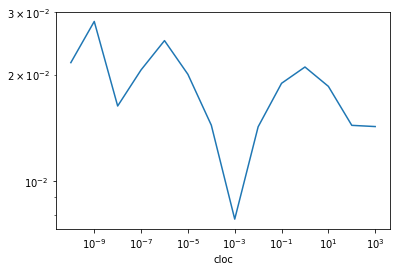

In [6]:
rang = np.logspace(-10,10,21)

rang = rang[:14]
errs = errs[:14]

from matplotlib import pyplot as plt
plt.figure()
plt.loglog(rang, errs)
plt.xlabel('cloc')
plt.legend(loc='upper right')
plt.show()

In [7]:
print errs

[0.021613171738342679, 0.028263051464992885, 0.0162954986060403, 0.020615542667883249, 0.024945814609909037, 0.020030178079278309, 0.014380221045781124, 0.0078012512413065949, 0.014232462561807808, 0.018891363817256559, 0.021007282058851495, 0.018519613609921676, 0.014367009817018439, 0.014253668887705982, 1.27581232455236, 1.156765172953264, 1.1617607103131384, 1.1617607101798317, 1.1617607101665215, 1.1617607101651719, 1.1617607101650183]


In [1]:
errs = [0.021613171738342679, 0.028263051464992885, 0.0162954986060403, 0.020615542667883249, 0.024945814609909037, 0.020030178079278309, 0.014380221045781124, 0.0078012512413065949, 0.014232462561807808, 0.018891363817256559, 0.021007282058851495, 0.018519613609921676, 0.014367009817018439, 0.014253668887705982, 1.27581232455236, 1.156765172953264, 1.1617607103131384, 1.1617607101798317, 1.1617607101665215, 1.1617607101651719, 1.1617607101650183]

In [2]:
from evaluations import *
p = maxwell_problem()
d, data = discretize_maxwell(p, diameter = 1./100)
mus = {'c_loc' : 1. / 376.730313 *1./200, 'k': 1e9*2*np.pi, 'mu': 4*np.pi*1e-7, 'eps': 8.854187817e-12}
u = d.solve(mus)
mus = {'c_loc' : 0, 'k': 1e9*2*np.pi, 'mu': 4*np.pi*1e-7, 'eps': 8.854187817e-12}
gq, lq = localize_problem(p, 10, 100, mus, dof_codim = 1, discretizer = discretize_maxwell)
basis = create_bases2(gq,lq,15,transfer = 'dirichlet', silent = False)
ru = reconstruct_solution(gq,lq,basis, silent = False)
dif = u-ru
err = d.h1_norm(dif)[0]/d.h1_norm(u)[0]
print err

localizing problem


/usr/lib/python2.7/dist-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


creating bases


/home/root_dennis/pymor_MA/src/pymor/operators/constructions.py:1002: RuntimeWarning: invalid value encountered in double_scalars
  if (np.linalg.norm(norm_squared.imag)/np.linalg.norm(norm_squared) > 1e-11):


reconstructing solution


mybmat.py:20: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(blocks) != 2:


0.0176412984002
